### import Libraries

In [1]:
import FinancialMachineLearning as fml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./Data/kospi_sample_2020.csv', index_col = 0)
df = fml.getDataFrame(df)
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
df

288.65
[  6.     6.05   6.   ... 100.7  100.75 100.5 ]
[0.14743169 0.14866029 0.14743169 ... 2.47439526 2.47562386 2.46948087]


,price,buy,sell,volume,v,dv
2020-01-02 10:00:00.000000,294.65,1120.0,0.0,1120.0,1120.0,330008.00
2020-01-02 10:00:00.104156,294.70,3.0,0.0,3.0,3.0,884.10
2020-01-02 10:00:00.208312,294.65,0.0,1.0,1.0,1.0,294.65
2020-01-02 10:00:00.312469,294.60,0.0,1.0,1.0,1.0,294.60
2020-01-02 10:00:00.416625,294.60,0.0,1.0,1.0,1.0,294.60
...,...,...,...,...,...,...
2020-12-30 15:34:59.026355,389.35,0.0,2.0,2.0,2.0,778.70
2020-12-30 15:34:59.348903,389.35,0.0,1.0,1.0,1.0,389.35
2020-12-30 15:34:59.671452,389.35,0.0,1.0,1.0,1.0,389.35
2020-12-30 15:34:59.994000,389.40,6.0,0.0,6.0,6.0,2336.40


Dollar Bar Sampling

In [3]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dollar_df

,price,buy,sell,volume,v,dv
2020-01-02 10:00:48.016031,295.10,60.0,0.0,60.0,60.0,17706.00
2020-01-02 10:01:59.751600,294.95,0.0,33.0,33.0,33.0,9733.35
2020-01-02 10:04:31.548569,294.75,0.0,113.0,113.0,113.0,33306.75
2020-01-02 10:06:39.158645,294.20,90.0,0.0,90.0,90.0,26478.00
2020-01-02 10:07:58.837489,293.75,0.0,22.0,22.0,22.0,6462.50
...,...,...,...,...,...,...
2020-12-30 15:27:20.310469,390.00,0.0,94.0,94.0,94.0,36660.00
2020-12-30 15:29:16.758887,389.55,0.0,70.0,70.0,70.0,27268.50
2020-12-30 15:30:30.202459,389.50,133.0,0.0,133.0,133.0,51803.50
2020-12-30 15:32:38.885000,389.45,0.0,2.0,2.0,2.0,778.90


Fractionally Differencing

In [4]:
import statsmodels.api as sm

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(dollar_df).resample('1H').last().dropna() # daily return
        df2 = fml.fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'price'], df2['price'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['price'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d.round(1)}, error: {e}')
        continue

d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.3, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.4, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.5, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,0.138046,9.685647e-01,1.0,1732.0,-2.863210,1.000000
0.6,-2.203507,2.049753e-01,1.0,9.0,-3.289881,0.819862
0.7,-3.178047,2.129107e-02,1.0,25.0,-2.986489,0.406898
0.8,-4.767002,6.286744e-05,1.0,72.0,-2.902607,0.524286
0.9,-10.386040,2.078861e-18,1.0,256.0,-2.872897,0.064845
1.0,-28.300219,0.000000e+00,1.0,1731.0,-2.863211,0.054125
1.1,-20.415279,0.000000e+00,1.0,745.0,-2.865427,0.057497
1.2,-22.787922,0.000000e+00,1.0,788.0,-2.865215,0.038205
1.3,-27.965855,0.000000e+00,1.0,952.0,-2.864581,0.020468
1.4,-32.086422,0.000000e+00,1.0,1146.0,-2.864065,0.017785


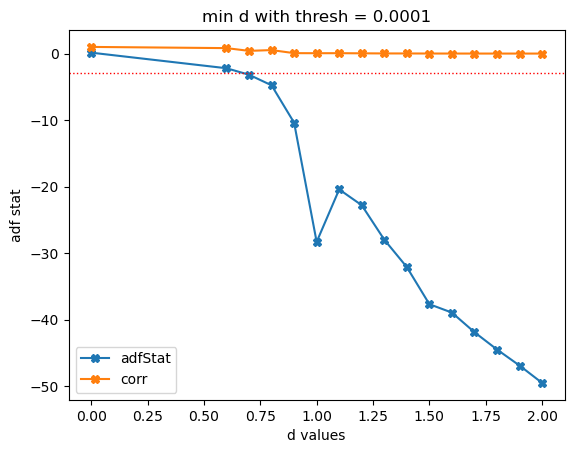

In [5]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat')
display(out)

In [6]:
min_ffd = out[out.pVal <= 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary", min_ffd.round(1))

The min. D that makes the fracdiff stationary 0.7


In [7]:
dfx2 = fml.fracDiff_FFD(dollar_df, min_ffd, thres = 1e-5)
dfx2

,price,buy,sell,volume,v,dv
2020-01-09 09:33:05.216870,1.452653,-14.271878,41.533105,27.261227,27.261227,8.022040e+03
2020-01-09 09:40:19.264128,1.749530,-11.360756,-61.658864,-73.019620,-73.019620,-2.138765e+04
2020-01-09 09:44:59.525297,1.816882,-11.605438,-10.247763,-21.853201,-21.853201,-6.382174e+03
2020-01-09 09:50:06.666000,1.404480,40.144861,-7.703151,32.441709,32.441709,9.539509e+03
2020-01-09 09:59:00.000000,1.545416,2.148488,-4.325105,-2.176617,-2.176617,-6.178915e+02
...,...,...,...,...,...,...
2020-12-30 15:27:20.310469,2.176185,-10.880614,84.628108,73.747494,73.747494,2.877185e+04
2020-12-30 15:29:16.758887,1.837930,-3.805661,-0.559160,-4.364821,-4.364821,-1.723414e+03
2020-12-30 15:30:30.202459,2.098589,130.215084,-61.994567,68.220518,68.220518,2.657139e+04
2020-12-30 15:32:38.885000,2.122545,-95.405461,-11.938372,-107.343833,-107.343833,-4.180588e+04


CUSUM Filtering

In [8]:
tEvents = fml.getTEvents(dfx2.price, h = dfx2.std().iat[0] * 2)
tEvents

DatetimeIndex(['2020-01-10 11:36:00.618495', '2020-01-14 09:48:48.929533',
               '2020-01-15 10:02:32.211544', '2020-01-17 09:44:14.316750',
               '2020-01-20 09:43:14.803714', '2020-01-20 11:19:03.839616',
               '2020-01-21 10:11:58.565571', '2020-01-22 14:24:29.121175',
               '2020-01-23 09:46:36.518087', '2020-01-28 09:41:00.495818',
               ...
               '2020-12-28 15:33:48.808678', '2020-12-29 09:41:17.791324',
               '2020-12-29 12:32:19.743248', '2020-12-29 13:11:08.999100',
               '2020-12-29 13:51:40.386205', '2020-12-29 13:56:56.134737',
               '2020-12-30 09:42:16.632000', '2020-12-30 10:21:03.488023',
               '2020-12-30 10:31:57.522337', '2020-12-30 11:58:29.384816'],
              dtype='datetime64[ns]', length=1143, freq=None)

In [9]:
dollar_feature = dollar_df.price.loc[tEvents]
dollar_feature

2020-01-10 11:36:00.618495    295.05
2020-01-14 09:48:48.929533    303.70
2020-01-15 10:02:32.211544    300.00
2020-01-17 09:44:14.316750    305.15
2020-01-20 09:43:14.803714    305.95
                               ...  
2020-12-29 13:56:56.134737    378.05
2020-12-30 09:42:16.632000    380.95
2020-12-30 10:21:03.488023    380.35
2020-12-30 10:31:57.522337    381.20
2020-12-30 11:58:29.384816    384.95
Name: price, Length: 1143, dtype: float64

In [10]:
frac_diff_feature = dfx2.loc[tEvents]
frac_diff_feature

,price,buy,sell,volume,v,dv
2020-01-10 11:36:00.618495,1.032436,-39.606688,41.501982,1.895294,1.895294,543.125821
2020-01-14 09:48:48.929533,2.194487,-86.356992,-9.091595,-95.448586,-95.448586,-28902.295791
2020-01-15 10:02:32.211544,1.791590,-79.461136,46.553467,-32.907669,-32.907669,-9858.804049
2020-01-17 09:44:14.316750,1.612268,-24.225321,-4.238501,-28.463822,-28.463822,-8649.770670
2020-01-20 09:43:14.803714,1.718007,-21.414928,-37.374088,-58.789016,-58.789016,-17941.126592
...,...,...,...,...,...,...
2020-12-29 13:56:56.134737,2.308008,-2.978881,-32.441284,-35.420165,-35.420165,-13371.162625
2020-12-30 09:42:16.632000,2.019787,-28.612481,-4.143015,-32.755497,-32.755497,-12478.012845
2020-12-30 10:21:03.488023,1.417918,-5.180933,40.718253,35.537320,35.537320,13514.455943
2020-12-30 10:31:57.522337,2.676054,-10.626243,-3.637101,-14.263343,-14.263343,-5424.554151


In [11]:
feature_Mat = (pd.DataFrame().assign(dollar = dollar_feature, frac_diff_dollar = frac_diff_feature.price).drop_duplicates().dropna())
feature_Mat

,dollar,frac_diff_dollar
2020-01-10 11:36:00.618495,295.05,1.032436
2020-01-14 09:48:48.929533,303.70,2.194487
2020-01-15 10:02:32.211544,300.00,1.791590
2020-01-17 09:44:14.316750,305.15,1.612268
2020-01-20 09:43:14.803714,305.95,1.718007
...,...,...
2020-12-29 13:56:56.134737,378.05,2.308008
2020-12-30 09:42:16.632000,380.95,2.019787
2020-12-30 10:21:03.488023,380.35,1.417918
2020-12-30 10:31:57.522337,381.20,2.676054


Volatility

In [12]:
dailyVol = fml.getDailyVolatility(feature_Mat.dollar)
dailyVol

2020-01-14 09:48:48.929533         NaN
2020-01-15 10:02:32.211544    0.029345
2020-01-17 09:44:14.316750    0.021269
2020-01-20 09:43:14.803714    0.017833
2020-01-20 11:19:03.839616    0.015373
                                ...   
2020-12-29 13:56:56.134737    0.011442
2020-12-30 09:42:16.632000    0.011335
2020-12-30 10:21:03.488023    0.011239
2020-12-30 10:31:57.522337    0.011131
2020-12-30 11:58:29.384816    0.011074
Name: dailyVol, Length: 1142, dtype: float64

<AxesSubplot:>

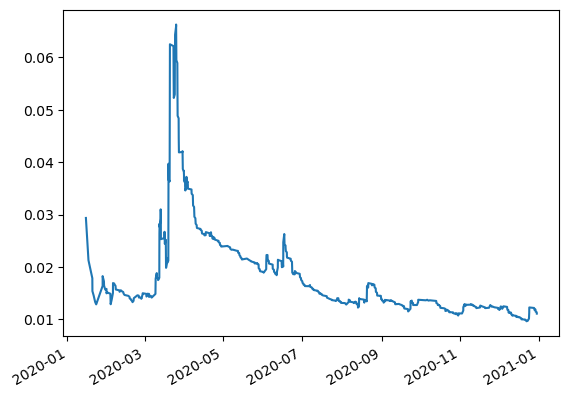

In [13]:
dailyVol.plot()

Vertical Barrier 지정

In [14]:
t1 = fml.addVerticalBarrier(tEvents, feature_Mat.dollar, numDays = 5)
t1

2020-01-10 11:36:00.618495   2020-01-17 09:44:14.316750
2020-01-14 09:48:48.929533   2020-01-20 09:43:14.803714
2020-01-15 10:02:32.211544   2020-01-20 11:19:03.839616
2020-01-17 09:44:14.316750   2020-01-22 14:24:29.121175
2020-01-20 09:43:14.803714   2020-01-28 09:41:00.495818
                                        ...            
2020-12-23 09:41:09.872430   2020-12-28 09:41:35.259632
2020-12-23 10:03:27.054515   2020-12-28 10:29:57.385565
2020-12-24 09:44:12.202169   2020-12-29 12:32:19.743248
2020-12-24 14:23:44.080472   2020-12-30 09:42:16.632000
2020-12-24 15:45:00.000000   2020-12-30 09:42:16.632000
Length: 1130, dtype: datetime64[ns]

In [15]:
import platform
from multiprocessing import cpu_count
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1
ptsl = [1,1]
target = dailyVol * 2
minRet = 0.001
cpus = cpu_count() - 1
events = fml.getEvents(feature_Mat.dollar, tEvents, ptsl, target, minRet, cpus, t1 = t1)

2023-05-08 19:31:08.140478 100.0% getTripleBarrier done after 0.09 minutes. Remaining 0.0 minutes.


In [16]:
events

,t1,trgt
2020-01-15 10:02:32.211544,2020-01-20 11:19:03.839616,0.058690
2020-01-17 09:44:14.316750,2020-01-22 14:24:29.121175,0.042538
2020-01-20 09:43:14.803714,2020-01-28 09:41:00.495818,0.035665
2020-01-20 11:19:03.839616,2020-01-28 09:41:00.495818,0.030747
2020-01-21 10:11:58.565571,2020-01-28 09:41:00.495818,0.029079
...,...,...
2020-12-29 13:56:56.134737,NaT,0.022883
2020-12-30 09:42:16.632000,NaT,0.022669
2020-12-30 10:21:03.488023,NaT,0.022477
2020-12-30 10:31:57.522337,NaT,0.022261


In [17]:
numCoEvents = fml.mpPandasObj(fml.getConcurrentBar, ('molecule', events.index), cpus, closeIdx = feature_Mat.index, t1 = events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep = 'last')]
numCoEvents = numCoEvents.reindex(feature_Mat.index).fillna(0)
out = pd.DataFrame()
out['tW'] = fml.mpPandasObj(fml.getAvgLabelUniq, ('molecule', events.index), cpus, t1 = events['t1'], numCoEvents = numCoEvents)
out

2023-05-08 19:31:13.869180 100.0% getConcurrentBar done after 0.08 minutes. Remaining 0.0 minutes..
2023-05-08 19:31:19.572535 100.0% getAvgLabelUniq done after 0.08 minutes. Remaining 0.0 minutes..


,tW
2020-01-15 10:02:32.211544,0.520833
2020-01-17 09:44:14.316750,0.306667
2020-01-20 09:43:14.803714,0.233333
2020-01-20 11:19:03.839616,0.213333
2020-01-21 10:11:58.565571,0.204167
...,...
2020-12-29 13:56:56.134737,0.085082
2020-12-30 09:42:16.632000,0.083625
2020-12-30 10:21:03.488023,0.083722
2020-12-30 10:31:57.522337,0.080128


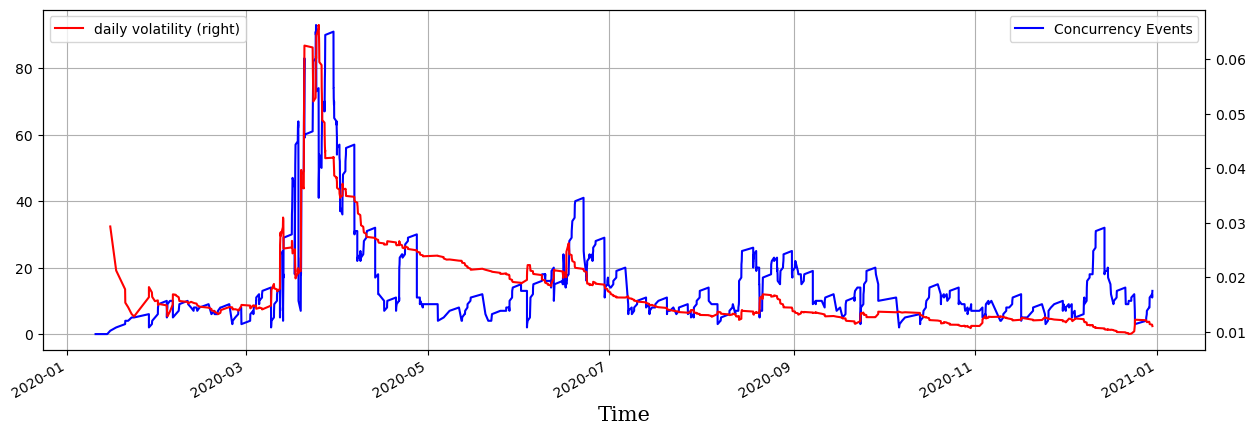

In [18]:
plt.figure(figsize = (15,5))
plt.xlabel('Time', fontfamily = 'Serif', fontsize = 15)

plt.style.use('default')
ax1 = numCoEvents.plot(color = 'blue', grid = True, label = 'Concurrency Events')
ax2 = dailyVol.plot(color = 'red', grid = True, secondary_y = True, label = 'daily volatility')

ax1.legend(loc = 1)
ax2.legend(loc = 2)

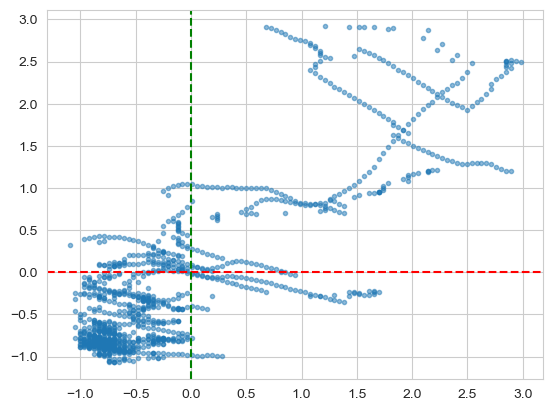

In [19]:
coEvents = numCoEvents.to_frame()
ewmasd = dailyVol.to_frame()
combine = ewmasd.join(coEvents, how = 'inner')
combine.columns = ['ewmasd', 'coEvents']
combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()
combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

sns.set_style('whitegrid')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'], marker = '.', alpha = 0.5)
plt.axhline(y = combine['coEvents_std'].mean(), c='r', ls='--')
plt.axvline(x = combine['ewmasd_std'].mean(), c='g', ls='--')
plt.show()

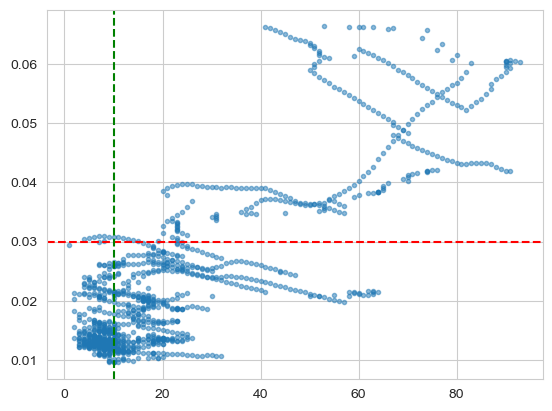

In [20]:
plt.scatter(combine['coEvents'], combine['ewmasd'], marker = '.', alpha = 0.5)
plt.axhline(y = 0.03, c='r', ls='--')
plt.axvline(x = 10, c='g', ls='--')
plt.show()

In [21]:
import statsmodels.api as sm
Xc = numCoEvents.groupby(level = 0).first()[2:]
Xc = sm.add_constant(Xc)
yc = dailyVol.dropna().values
model = sm.OLS(yc, Xc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     2369.
Date:                Mon, 08 May 2023   Prob (F-statistic):          1.65e-280
Time:                        19:31:20   Log-Likelihood:                 3876.6
No. Observations:                1141   AIC:                            -7749.
Df Residuals:                    1139   BIC:                            -7739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0115      0.000     31.607      0.000       0.011       0.012
0              0.0005   1.06e-05     48.675      0.000       0.000       0.001
==============================================================================
Omnibus:                      125.520   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.976
Skew:                           0.669   Prob(JB):                     5.81e-57
Kurtosis:                       4.912   Cond. No.                         52.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
out['w'] = fml.mpPandasObj(fml.mpSampleW, ('molecule', events.index),
                           cpus, t1 = events['t1'], numCoEvents = numCoEvents, close = feature_Mat.dollar)
out['w'] *= out.shape[0] / out['w'].sum()
out

2023-05-08 19:31:25.688503 100.0% mpSampleW done after 0.08 minutes. Remaining 0.0 minutes.


,tW,w
2020-01-15 10:02:32.211544,0.520833,0.893930
2020-01-17 09:44:14.316750,0.306667,5.396178
2020-01-20 09:43:14.803714,0.233333,3.169945
2020-01-20 11:19:03.839616,0.213333,3.679853
2020-01-21 10:11:58.565571,0.204167,4.465469
...,...,...
2020-12-29 13:56:56.134737,0.085082,0.914313
2020-12-30 09:42:16.632000,0.083625,0.836984
2020-12-30 10:21:03.488023,0.083722,0.464924
2020-12-30 10:31:57.522337,0.080128,0.548646


Labeling

In [23]:
labels = fml.getBins(events, feature_Mat.dollar)
clean_labels = fml.dropLabels(labels, 0.05)
clean_labels

dropped label 0.0 0.0035366931918656055


,ret,bin
2020-01-15 10:02:32.211544,0.025333,1.0
2020-01-17 09:44:14.316750,0.002622,1.0
2020-01-20 09:43:14.803714,-0.034810,-1.0
2020-01-20 11:19:03.839616,-0.039987,-1.0
2020-01-21 10:11:58.565571,-0.031962,-1.0
...,...,...
2020-12-24 14:23:44.080472,0.019401,1.0
2020-12-24 15:45:00.000000,0.018311,1.0
2020-12-28 10:29:57.385565,0.024212,1.0
2020-12-28 14:47:35.435053,0.027767,1.0


In [24]:
clean_labels.bin.value_counts()

 1.0    680
-1.0    447
Name: bin, dtype: int64

Feature Matrix

In [25]:
from multiprocessing import Pool
import test

if __name__ == "__main__":
    with Pool() as pool:
        seqUs = test.main_mp(t1)
        #result = pool.map(test.main_mp(t1), range(10))
        #print(result)

2023-05-08 19:31:37.483021 100.0% mp_func done after 0.18 minutes. Remaining 0.0 minutes.


In [26]:
avg_uniqueness = seqUs.mean()[0]
avgU1 = out['tW'].mean()

In [27]:
target = clean_labels.bin
target

2020-01-15 10:02:32.211544    1.0
2020-01-17 09:44:14.316750    1.0
2020-01-20 09:43:14.803714   -1.0
2020-01-20 11:19:03.839616   -1.0
2020-01-21 10:11:58.565571   -1.0
                             ... 
2020-12-24 14:23:44.080472    1.0
2020-12-24 15:45:00.000000    1.0
2020-12-28 10:29:57.385565    1.0
2020-12-28 14:47:35.435053    1.0
2020-12-28 15:33:48.808678    1.0
Name: bin, Length: 1127, dtype: float64

In [28]:
data = feature_Mat.join(out, how = 'left').join(target, how = 'left').dropna()
data

,dollar,frac_diff_dollar,tW,w,bin
2020-01-15 10:02:32.211544,300.00,1.791590,0.520833,0.893930,1.0
2020-01-17 09:44:14.316750,305.15,1.612268,0.306667,5.396178,1.0
2020-01-20 09:43:14.803714,305.95,1.718007,0.233333,3.169945,-1.0
2020-01-20 11:19:03.839616,307.60,2.333665,0.213333,3.679853,-1.0
2020-01-21 10:11:58.565571,305.05,1.049476,0.204167,4.465469,-1.0
...,...,...,...,...,...
2020-12-24 14:23:44.080472,373.70,2.827631,0.155922,2.526472,1.0
2020-12-24 15:45:00.000000,374.10,3.003412,0.157110,1.684682,1.0
2020-12-28 10:29:57.385565,375.85,2.711431,0.116337,0.852089,1.0
2020-12-28 14:47:35.435053,374.55,1.285100,0.108731,1.178079,1.0


Bagging, Random Forest, Catboost

In [29]:
X = data.iloc[:,:-1].values # dollar, frac_diff, tW, w
y = data.iloc[:,-1].values.reshape(-1,1) # bin

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, random_state = 42)

In [31]:
n_estimator = 1000
dt = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', class_weight = 'balanced')
bc = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                       max_samples = avgU1, max_features = 1., random_state = 42)

In [32]:
fit = bc.fit(X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.68      0.64      0.66       447
       trade       0.77      0.81      0.79       680

    accuracy                           0.74      1127
   macro avg       0.73      0.72      0.73      1127
weighted avg       0.74      0.74      0.74      1127



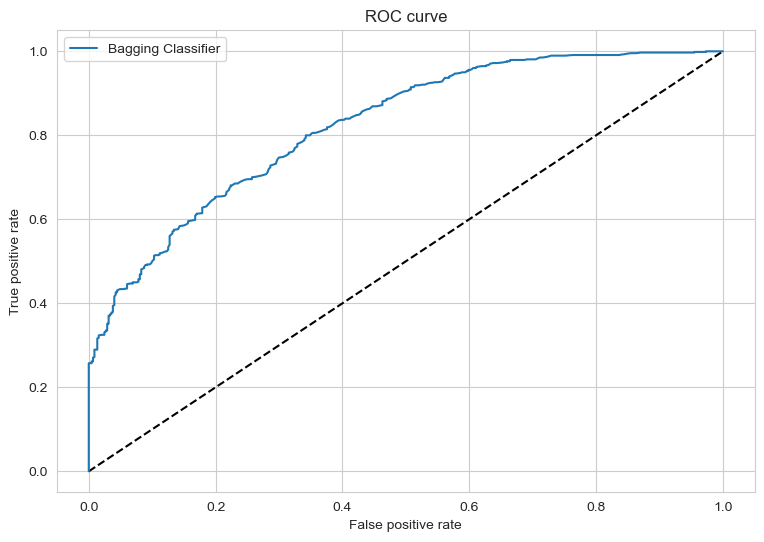

In [33]:
from sklearn import metrics
# The random forest model by itself
y_pred_rf = fit.predict_proba(X)[:, 1]
y_pred = fit.predict(X)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
print(metrics.classification_report(y, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [34]:
n_estimator = 1000
rf = RandomForestClassifier(n_estimators = n_estimator, criterion = 'entropy', random_state = 42,
                            class_weight = 'balanced_subsample', ccp_alpha = 0.001)
fit = rf.fit(X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.70      0.97      0.81       447
       trade       0.98      0.72      0.83       680

    accuracy                           0.82      1127
   macro avg       0.84      0.85      0.82      1127
weighted avg       0.87      0.82      0.82      1127



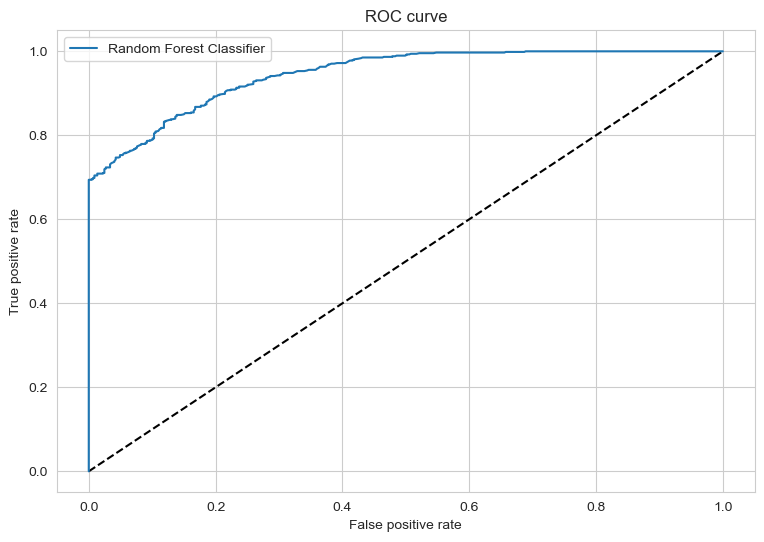

In [35]:
y_pred_rf = fit.predict_proba(X)[:, 1]
y_pred = fit.predict(X)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
print(metrics.classification_report(y, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Time Decay** 지정

1.0 0.0
-0.0495 0.0135
-0.765 0.0227
-1.9684 0.0382
-2.6832 0.0474
-3.9922 0.0643


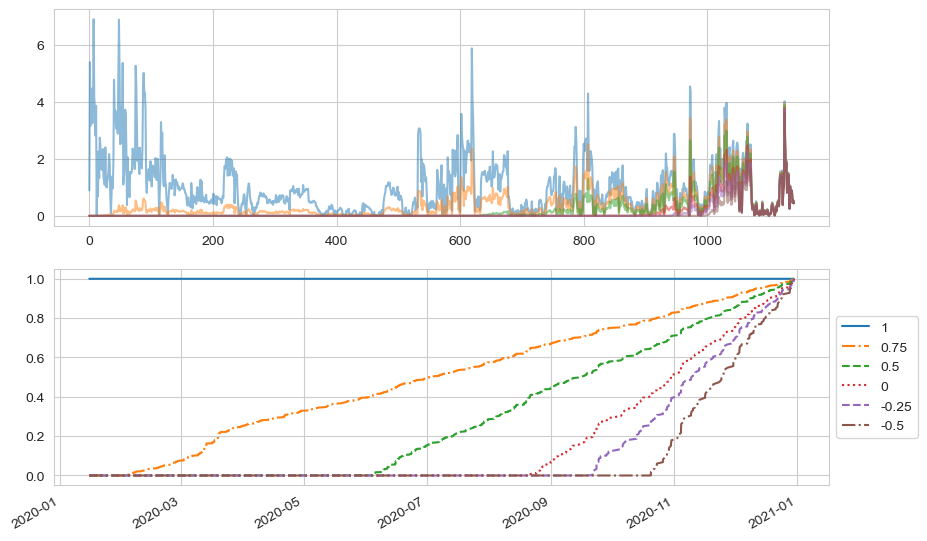

In [36]:
def getExTimeDecay(tW, clfLastW = 1.,exponent = 1):
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0: slope = ((1.-clfLastW)/clfW.iloc[-1]) ** exponent
    else: slope = (1./((clfLastW + 1) * clfW.iloc[-1])) ** exponent
    const = 1.-slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    print(round(const, 4), round(slope, 4))
    return clfW

f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(),
                                 clfLastW = lstW,
                                 exponent = 0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index = out['w'].dropna().index) * decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [37]:
out

,tW,w
2020-01-15 10:02:32.211544,0.520833,0.893930
2020-01-17 09:44:14.316750,0.306667,5.396178
2020-01-20 09:43:14.803714,0.233333,3.169945
2020-01-20 11:19:03.839616,0.213333,3.679853
2020-01-21 10:11:58.565571,0.204167,4.465469
...,...,...
2020-12-29 13:56:56.134737,0.085082,0.914313
2020-12-30 09:42:16.632000,0.083625,0.836984
2020-12-30 10:21:03.488023,0.083722,0.464924
2020-12-30 10:31:57.522337,0.080128,0.548646


In [38]:
s

2020-01-15 10:02:32.211544    0.000000
2020-01-17 09:44:14.316750    0.000000
2020-01-20 09:43:14.803714    0.000000
2020-01-20 11:19:03.839616    0.000000
2020-01-21 10:11:58.565571    0.000000
                                ...   
2020-12-29 13:56:56.134737    0.979142
2020-12-30 09:42:16.632000    0.984519
2020-12-30 10:21:03.488023    0.989902
2020-12-30 10:31:57.522337    0.995054
2020-12-30 11:58:29.384816    1.000000
Length: 1141, dtype: float64

In [39]:
data['s'] = s
data

,dollar,frac_diff_dollar,tW,w,bin,s
2020-01-15 10:02:32.211544,300.00,1.791590,0.520833,0.893930,1.0,0.000000
2020-01-17 09:44:14.316750,305.15,1.612268,0.306667,5.396178,1.0,0.000000
2020-01-20 09:43:14.803714,305.95,1.718007,0.233333,3.169945,-1.0,0.000000
2020-01-20 11:19:03.839616,307.60,2.333665,0.213333,3.679853,-1.0,0.000000
2020-01-21 10:11:58.565571,305.05,1.049476,0.204167,4.465469,-1.0,0.000000
...,...,...,...,...,...,...
2020-12-24 14:23:44.080472,373.70,2.827631,0.155922,2.526472,1.0,0.910406
2020-12-24 15:45:00.000000,374.10,3.003412,0.157110,1.684682,1.0,0.920508
2020-12-28 10:29:57.385565,375.85,2.711431,0.116337,0.852089,1.0,0.936129
2020-12-28 14:47:35.435053,374.55,1.285100,0.108731,1.178079,1.0,0.943121


In [40]:
X = data.iloc[:,[0,1,2,3,5]].values # dollar, frac_diff, tW, w, s
y = data.iloc[:,-2].values.reshape(-1,1) # bin

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, random_state = 42)

In [42]:
n_estimator = 100
dt = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', class_weight = 'balanced')
bc = BaggingClassifier(base_estimator = dt, n_estimators = n_estimator,
                       max_samples = avgU1, max_features = 1., random_state = 42)

In [43]:
fit = bc.fit(X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.68      0.62      0.65       447
       trade       0.76      0.81      0.78       680

    accuracy                           0.73      1127
   macro avg       0.72      0.71      0.72      1127
weighted avg       0.73      0.73      0.73      1127



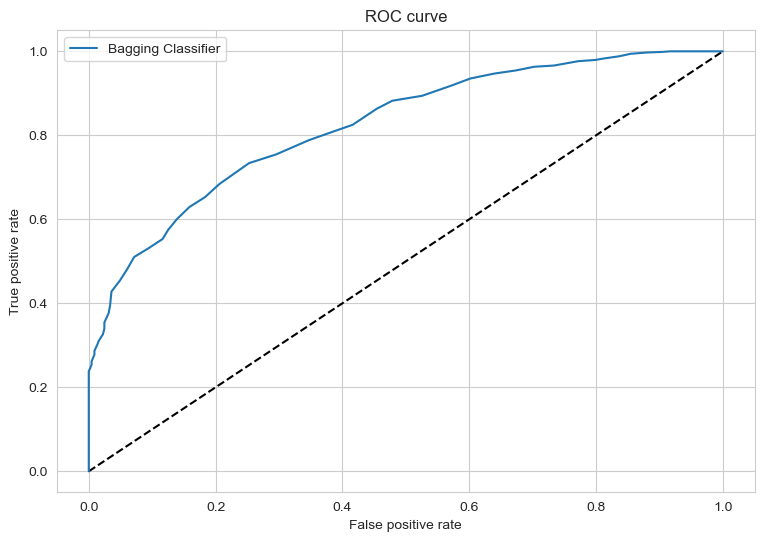

In [44]:
y_pred_rf = fit.predict_proba(X)[:, 1]
y_pred = fit.predict(X)
fpr_bc, tpr_bc, _ = metrics.roc_curve(y, y_pred_rf)
print(metrics.classification_report(y, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [45]:
n_estimator = 100
rf = RandomForestClassifier(n_estimators = n_estimator, criterion = 'entropy', random_state = 42,
                            class_weight = 'balanced_subsample', ccp_alpha = 0.001)
fit = rf.fit(X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.70      0.97      0.81       447
       trade       0.97      0.73      0.83       680

    accuracy                           0.82      1127
   macro avg       0.84      0.85      0.82      1127
weighted avg       0.87      0.82      0.83      1127



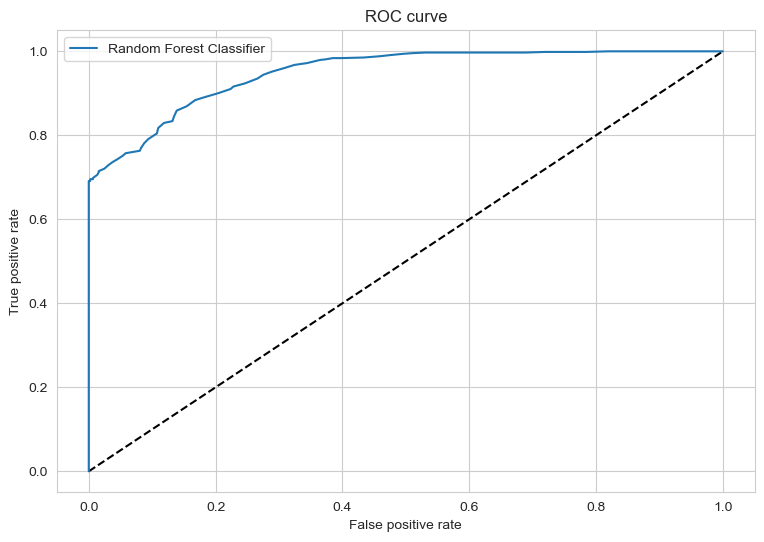

In [46]:
y_pred_rf = fit.predict_proba(X)[:, 1]
y_pred = fit.predict(X)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y, y_pred_rf)
print(metrics.classification_report(y, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [47]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train.reshape(1,-1))
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train.reshape(-1,))
classes_tuple = tuple(classes)
weights_tuple = tuple(weights)

class_weights = dict(zip(classes_tuple, weights_tuple))

**Classifier**

random_seed = 42

class_weights = 'balanced'

learning_rate = 0.05

loss_function = MultiClass (same as log_loss, entropy)

iterations = 500

n_estimators = 1000

early_stopping_rounds = 20

In [48]:
cb = CatBoostClassifier(iterations = 1000, learning_rate = 0.05, depth = 2,
                        class_weights = class_weights, loss_function = 'Logloss', 
                        random_seed = 42, early_stopping_rounds = 2000, has_time = True,
                        od_type = 'IncToDec', od_pval = 0.05)
fit = cb.fit(X_train, y_train)

0:	learn: 0.6798082	total: 59.9ms	remaining: 59.8s
1:	learn: 0.6681445	total: 60.5ms	remaining: 30.2s
2:	learn: 0.6586307	total: 60.9ms	remaining: 20.2s
3:	learn: 0.6508459	total: 61.3ms	remaining: 15.3s
4:	learn: 0.6439900	total: 61.7ms	remaining: 12.3s
5:	learn: 0.6359617	total: 62.1ms	remaining: 10.3s
6:	learn: 0.6275080	total: 62.4ms	remaining: 8.85s
7:	learn: 0.6239729	total: 62.8ms	remaining: 7.78s
8:	learn: 0.6192918	total: 63.3ms	remaining: 6.97s
9:	learn: 0.6174404	total: 63.7ms	remaining: 6.3s
10:	learn: 0.6135255	total: 64ms	remaining: 5.76s
11:	learn: 0.6106983	total: 64.4ms	remaining: 5.3s
12:	learn: 0.6078959	total: 64.8ms	remaining: 4.92s
13:	learn: 0.6057187	total: 65.1ms	remaining: 4.58s
14:	learn: 0.5997198	total: 65.5ms	remaining: 4.3s
15:	learn: 0.5978475	total: 65.8ms	remaining: 4.05s
16:	learn: 0.5965424	total: 66.1ms	remaining: 3.82s
17:	learn: 0.5943538	total: 66.4ms	remaining: 3.63s
18:	learn: 0.5930143	total: 66.8ms	remaining: 3.45s
19:	learn: 0.5909172	total:

548:	learn: 0.3166135	total: 249ms	remaining: 205ms
549:	learn: 0.3164226	total: 250ms	remaining: 204ms
550:	learn: 0.3163849	total: 250ms	remaining: 204ms
551:	learn: 0.3161470	total: 250ms	remaining: 203ms
552:	learn: 0.3159326	total: 251ms	remaining: 203ms
553:	learn: 0.3157267	total: 251ms	remaining: 202ms
554:	learn: 0.3155470	total: 251ms	remaining: 202ms
555:	learn: 0.3151235	total: 252ms	remaining: 201ms
556:	learn: 0.3148360	total: 252ms	remaining: 201ms
557:	learn: 0.3146840	total: 253ms	remaining: 200ms
558:	learn: 0.3145098	total: 253ms	remaining: 199ms
559:	learn: 0.3143947	total: 253ms	remaining: 199ms
560:	learn: 0.3141154	total: 253ms	remaining: 198ms
561:	learn: 0.3137295	total: 254ms	remaining: 198ms
562:	learn: 0.3134178	total: 254ms	remaining: 197ms
563:	learn: 0.3132619	total: 254ms	remaining: 197ms
564:	learn: 0.3130961	total: 255ms	remaining: 196ms
565:	learn: 0.3128426	total: 255ms	remaining: 195ms
566:	learn: 0.3127288	total: 255ms	remaining: 195ms
567:	learn: 

              precision    recall  f1-score   support

    no trade       0.65      0.96      0.78       447
       trade       0.97      0.66      0.78       680

    accuracy                           0.78      1127
   macro avg       0.81      0.81      0.78      1127
weighted avg       0.84      0.78      0.78      1127



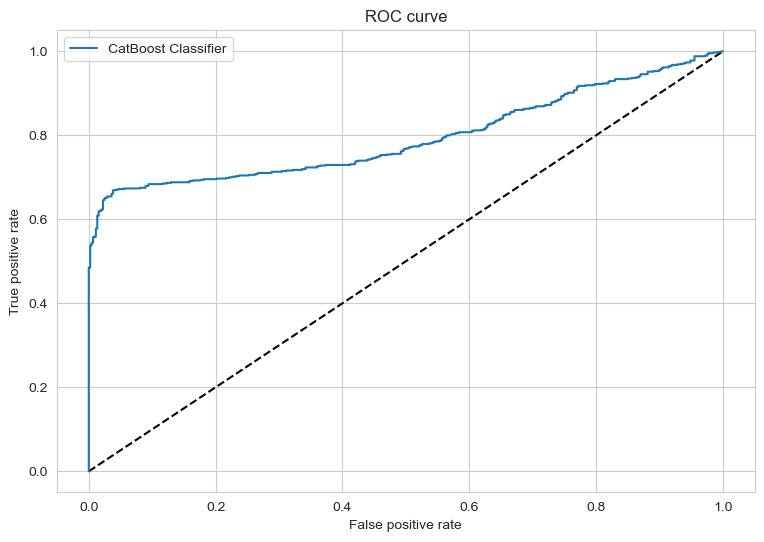

In [49]:
y_pred_rf = fit.predict_proba(X)[:, 1]
y_pred = fit.predict(X)
fpr_cb, tpr_cb, _ = metrics.roc_curve(y, y_pred_rf)
print(metrics.classification_report(y, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cb, tpr_cb, label = 'CatBoost Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
n_estimator = 100
rf2 = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', bootstrap = False, class_weight = 'balanced_subsample')
bc2 = BaggingClassifier(base_estimator = rf2, n_estimators = n_estimator,
                        max_samples = avgU1, max_features = 1., random_state = 42)

In [51]:
fit = bc2.fit(X_train, y_train)

              precision    recall  f1-score   support

    no trade       0.66      0.68      0.67       447
       trade       0.79      0.77      0.78       680

    accuracy                           0.73      1127
   macro avg       0.72      0.73      0.72      1127
weighted avg       0.74      0.73      0.74      1127



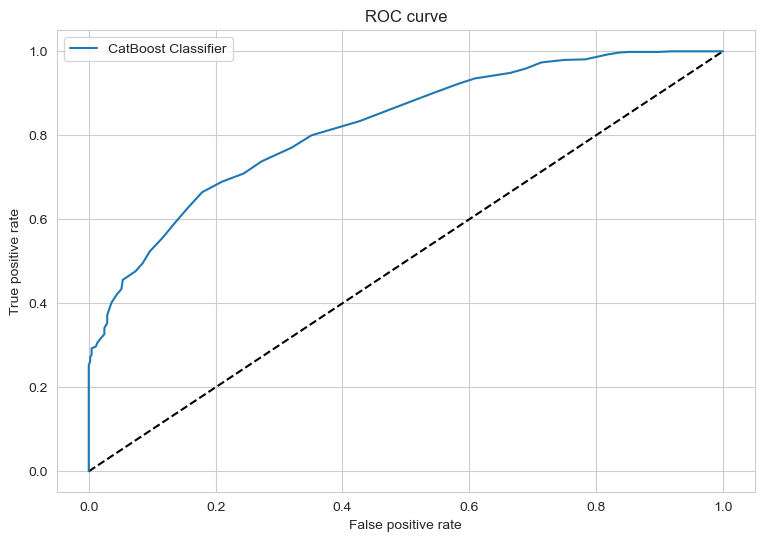

In [52]:
y_pred_rf = fit.predict_proba(X)[:, 1]
y_pred = fit.predict(X)
fpr_bc2, tpr_bc2, _ = metrics.roc_curve(y, y_pred_rf)
print(metrics.classification_report(y, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc2, tpr_bc2, label = 'CatBoost Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

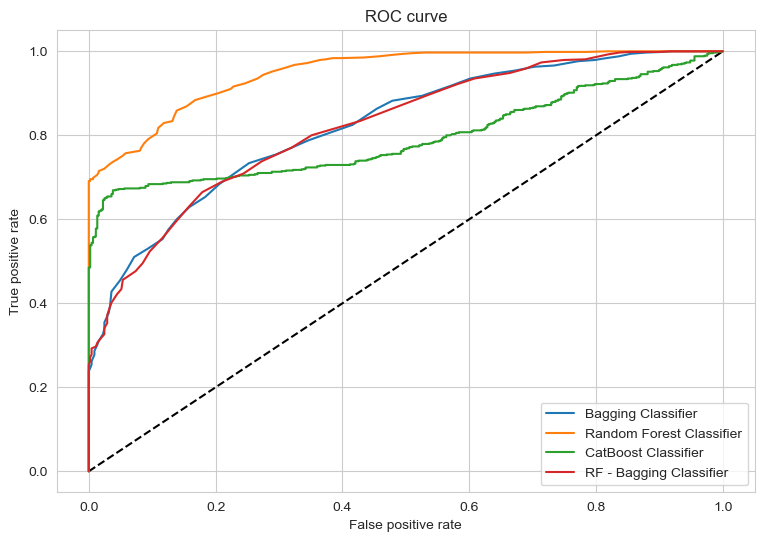

In [53]:
plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'Bagging Classifier')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.plot(fpr_cb, tpr_cb, label = 'CatBoost Classifier')
plt.plot(fpr_bc2, tpr_bc2, label = 'RF - Bagging Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()